# Learning by ONLY pruning

Despite the focus on gradient-based learning, a large portion of learning in brain is achieved through synaptic pruning. This notebook experiments with pruning the neural tangent ensemble as a method of learning.

# Functions

In [2]:
import torch
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import copy
from tqdm import tqdm


In [3]:
## Create the problem

def shuffled_MNIST(batch_size, dataset_folder='./data'):
    """Create a MNIST dataset in which pixels are shuffled, and return the test and train dataloaders.
    Uses a new random seed every time it's called.

    Arguments:    batch_size: tha batch size
                  dataself_folder: path to the mnist dataset, or where it should go once downloaded

    """

    kwargs = {'num_workers': 0, 'pin_memory': True}

    permute_mask = torch.randperm(784)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(784)[permute_mask])
        ])

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dataset_folder, train=True, download=True,
                       transform=transform),
        batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dataset_folder, train=False, transform=transform),
        batch_size=batch_size, shuffle=False, drop_last=True, **kwargs)

    return (train_loader, test_loader)

train_loader, test_loader = shuffled_MNIST(128)
for a,b in train_loader:
  print(a.shape, b.shape)
  break

torch.Size([128, 784]) torch.Size([128])


In [4]:


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, num_features, n_layers=2):
        super(MLP, self).__init__()
        self.num_features = num_features

        # Initialize the fixed random weights for the first layer
        self.first_layer_weights = nn.Linear(input_dim, num_features)

        # mid layers
        self.mid_layers = nn.ModuleList([nn.Linear(num_features, num_features) for _ in range(n_layers-2)])

        # The second layer is learnable
        self.linear = nn.Linear(num_features, output_dim)

        self.linear.bias.data.fill_(0)
 

    def forward(self, x, ):
        x = self.first_layer_weights(x)
        x = torch.relu(x)

        for layer in self.mid_layers:
            x = layer(x)
            x = torch.relu(x)
        
        output = self.linear(x)

        return output
def count_zero_edges(model):
    zero_edges = 0
    total_edges = 0
    for p in model.parameters():
        zero_edges += (p == 0).sum().item()
        total_edges += p.numel()
    return zero_edges, total_edges



def number_equal_edges(model_params, init_model_params):
    edges = 0
    for p, p_2 in zip(model_params, init_model_params):
        edges += (p==p_2).sum().item()
    return edges

def count_total_edges(model):
    edges = 0
    for p in model.parameters():
        edges += p.numel()
    return edges

In [5]:
from tqdm import tqdm

        
def train_and_evaluate(model, train_loader, test_loaders, optimizer, num_epochs, device, eval_interval, test_batches=10,log_edges=False):
    model.to(device)  # Move the model to the appropriate device
    all_accuracies = {i: [] for i in range(len(test_loaders))}  # Dictionary to store accuracies
    total_edges = count_total_edges(model)
    batch_count = 0  # Counter for tracking the number of batches
    accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for data, target in t:
                data, target = data.to(device), target.to(device)  # Move data to the appropriate device
                optimizer.zero_grad()
                output = model(data)
                loss = nn.CrossEntropyLoss()(output, target)
                loss.backward()
                optimizer.step()
                batch_count += 1

                if batch_count % eval_interval == 0:
                    model.eval()
                    with torch.no_grad():
                        for i, test_loader in enumerate(test_loaders):
                            correct = 0
                            total = 0
                            j = 0
                            for data, target in test_loader:
                                data, target = data.to(device), target.to(device)
                                output = model(data)
                                _, predicted = torch.max(output.data, 1)
                                total += target.size(0)
                                correct += (predicted == target).sum().item()
                                j += 1
                                if j >= test_batches:
                                    break
                            accuracy = 100 * correct / total
                            all_accuracies[i].append(accuracy)
                    model.train()

                n_zero_edges = number_equal_edges(model.parameters(), optimizer.init_param_groups_fn()[0]['params']) if log_edges else 0
                t.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f} - Restored edges: {n_zero_edges} / {total_edges} - Test accuracy: {accuracy:.2f}%")

    return all_accuracies

def plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader):
    offset = len(train_loader) // eval_interval * num_epochs

    plt.figure(figsize=(10, 6))
    for i, accs in enumerate(all_accuracies):
        accs = np.concatenate([[0]*(i*offset+1)]+[a.get(i,[]) for a in all_accuracies])

        plt.plot(accs, label=f'Task {i+1}')
        plt.vlines(range(0,num_rounds*offset, offset), 0, 100, linestyles=":", colors="r")
    plt.xlabel('Epoch')
    plt.ylabel('Test accuracy on Task (%)')
    plt.title('Accuracy on All Tasks During Continual Learning')
    plt.legend()
    plt.show()

In [22]:


def reinitialize_with_sign(model, magnitude=.001):
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            with torch.no_grad():
                weight_sign = module.weight.sign() * magnitude
                module.weight.copy_(weight_sign)

def perturb_model(model, noise_scale):
    for p in model.parameters():
        p.data += torch.randn_like(p.data) * noise_scale
    return model

def perturb_model_bernoulli(model, noise_scale):
    for p in model.parameters():
        p.data += torch.sign(torch.randn_like(p.data)) * noise_scale
    return model
    
    
from scipy.stats import norm

from tqdm import tqdm

class NTKPruner(optim.Optimizer):
    """
    Prunes the weights of a model by a certain fraction at each step. 

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups
        init_model (nn.Module): A copy of the model at initalization. If None, the ∆W just becomes W.
        prune_rate (float): approximate fraction of weights to prune at each step. Computes the percentile over each parameter group.
        momentum (float): momentum for the exponential moving average of the data likelihood
        cutoff_method (str): Method by which to estimate the cutoff for pruning so as to zero out prune_rate fraction of weights.
                            Choices are 'percentile' and 'gaussian'.
        bayes (bool): If True, we interpret the network as an (additive) ensemble of models, and prune based on the data likelihood
                     given each tangent model, which is data_log_likelihood = -(torch.log1p(- sign_delta_p * d_p * self.temperature)) 
                     If False, we prune based on the gradient of the loss, which is data_log_likelihood = -d_p * sign_delta_p
                     . This allows aggregating gradients across examples, and corresponds to the PoE interpretation.
        temperature (float): temperature for the Bayes ensemble. Must be low enough to prevent NaNs in the log likelihood.

    """

    def __init__(self, params, init_model, prune_rate= object(), momentum=0, cutoff_method='percentile', bayes=False,temperature=.1,**kwargs):
        defaults = dict(prune_rate=prune_rate, momentum=momentum, cutoff_method=cutoff_method)
        super(NTKPruner, self).__init__(params, defaults)
        assert 0 <= prune_rate <= 1, f"Prune rate must be between 0 and 1, got {prune_rate}"
        assert cutoff_method in ['percentile', 'gaussian', ], f"Invalid cutoff method {cutoff_method}"
        if cutoff_method == 'gaussian':
            self.high_Z = norm.ppf(1 - prune_rate)
            self.low_Z = norm.ppf(prune_rate)
        self.temperature = temperature
        self.bayes = bayes
        self.zero_init = init_model is None
        if len(self.param_groups) > 1:
            if init_model is None:
                self.init_param_groups_fn = lambda: [{'params': [None] * len(group['params'])} for group in self.param_groups]
            else:
                self.init_param_groups_fn = lambda: init_model.parameters()  # this function returns a generator. Better than storing list(params)
        else:
            if init_model is None:
                self.init_param_groups_fn = lambda: [{'params': [None] * len(self.param_groups[0]['params'])}]
            else:
                self.init_param_groups_fn = lambda: [{'params': init_model.parameters()}]
        
        # Check that no parameters are zero if no init model is supplied
        if self.zero_init:
            for group in self.param_groups:
                for p in group['params']:
                    assert not torch.any(p.data == 0), "A parameter is initialized to zero. This will prevent any learning on this parameter."

    def __setstate__(self, state):
        super(Pruner, self).__setstate__(state)

    def step(self, closure=None, ):
        """Performs a single optimization step.

        Arguments:
            closure (callable): A closure that re-evaluates the model, runs `backward`,
                and returns the loss.
        """

        loss = None
        if closure is not None:
            loss = closure()

        # take a proposed step.
        for group, init_param_group in zip(self.param_groups, self.init_param_groups_fn()):
            prune_rate = group['prune_rate']
            momentum = group['momentum']
            cutoff_method = group['cutoff_method']

            for p, p_c in zip(group['params'], init_param_group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data

                if d_p.is_sparse:             

                    raise NotImplementedError("Sparse tensors are not supported yet")

                if self.zero_init:
                    # If init_params is None, use the current gradients divided by 2 for linearization
                    delta_p = p.data
                    d_p = d_p / 2
                else:
                    delta_p = p.data - p_c.data

                sign_delta_p = torch.sign(delta_p)

                if self.bayes:
                    data_likelihood = -(torch.log1p(- sign_delta_p * d_p * self.temperature)) 
                    x = data_likelihood
                else:
                    x = d_p 

                assert not torch.any(torch.isnan(x)), f"NaNs in x, d_p, or delta_p. x: {x[torch.isnan(x)]}, d_p: {d_p[torch.isnan(x)]}, delta_p: {delta_p[torch.isnan(x)]}"

                if momentum > 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        v = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        v.mul_(momentum).add_(x * (1 - momentum))
                    else:
                        v = param_state['momentum_buffer']
                        v.mul_(momentum).add_(x * (1 - momentum))
                else:
                    v = x

                f = v if self.bayes else v * sign_delta_p
                nonzero_f = f[f != 0]
                if len(nonzero_f) == 0:
                    continue
                # we prune those with the most positive (gradient of the loss) * ∆W
                # we omit 0s from the percentile as they are already pruned
                if cutoff_method == 'percentile':
                    cutoff = torch.quantile(nonzero_f, 1 - prune_rate)
                elif cutoff_method == 'gaussian':
                    cutoff = nonzero_f.mean() + nonzero_f.std() * self.high_Z
                elif cutoff_method == 'subsampled_percentile':
                    cutoff = torch.quantile(nonzero_f[:10000], 1 - prune_rate)
                to_keep = f < cutoff

                if self.zero_init:
                    p.data = p.data * to_keep
                else:
                    p.data = torch.where(to_keep, p.data, p_c.data) # or p_c.data + to_keep * delta_p. Maybe faster.
                       

        return loss


# Tests


## Benchmark: SGD on a 2LMLP

Epoch 1/1 - Loss: 0.1755 - Restored edges: 0 / 79500010 - Test accuracy: 92.42%: 100%|██████████| 468/468 [00:12<00:00, 38.27it/s]
Epoch 1/1 - Loss: 0.1694 - Restored edges: 0 / 79500010 - Test accuracy: 92.50%: 100%|██████████| 468/468 [00:17<00:00, 26.05it/s]
Epoch 1/1 - Loss: 0.2344 - Restored edges: 0 / 79500010 - Test accuracy: 92.11%: 100%|██████████| 468/468 [00:20<00:00, 22.83it/s]
Epoch 1/1 - Loss: 0.0978 - Restored edges: 0 / 79500010 - Test accuracy: 91.09%: 100%|██████████| 468/468 [00:26<00:00, 17.87it/s]
Epoch 1/1 - Loss: 0.2084 - Restored edges: 0 / 79500010 - Test accuracy: 92.11%: 100%|██████████| 468/468 [00:28<00:00, 16.18it/s]
Epoch 1/1 - Loss: 0.1577 - Restored edges: 0 / 79500010 - Test accuracy: 90.16%: 100%|██████████| 468/468 [00:32<00:00, 14.25it/s]
Epoch 1/1 - Loss: 0.2702 - Restored edges: 0 / 79500010 - Test accuracy: 92.11%: 100%|██████████| 468/468 [00:36<00:00, 12.74it/s]
Epoch 1/1 - Loss: 0.1994 - Restored edges: 0 / 79500010 - Test accuracy: 92.03%: 10

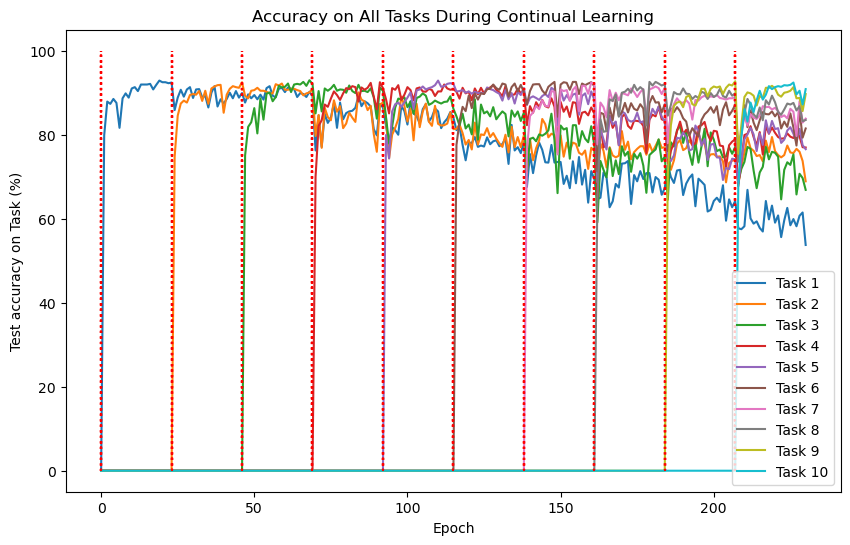

In [22]:

num_rounds = 10  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []
zero_edges = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
optimizer = optim.SGD(model.parameters(),0.01, weight_decay=0)

eval_interval = 20
for round in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(128)  # Create new shuffled dataset

    # Update all test loaders to include the new test set
    if round == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optimizer, num_epochs, device, eval_interval, test_batches=10,log_edges=False)
    all_accuracies.append(accuracies)

plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader)

Text(0.5, 1.0, 'Noise level 0.001')

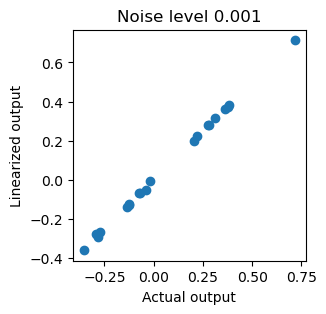

In [7]:


def linearized_model_forward(model, init_model, x):
    """Return the output of the linearized model around the initialization, i.e., the NTK approximation."""
    # Compute the output of the model at the initialization
    init_output = init_model(x)

    # Initialize the linearized output with the detached initial output
    linearized_output = init_output.detach().clone()

    # Iterate over each example and dimension. Needed due to autograd limitations. 
    for i in range(x.size(0)):
        for j in range(init_output.size(1)):
            # Compute the gradient of the model output with respect to the parameters for this example
            init_grads_example = torch.autograd.grad(init_output[i,j], init_model.parameters(), retain_graph=True)

            # Update the linearized output for each parameter and each output dimension
            for param, init_param, grad in zip(model.parameters(), init_model.parameters(), init_grads_example):
                delta_param = (param - init_param.detach())
                linearized_output[i, j] += torch.sum(grad.detach() * delta_param)
    return linearized_output


s = 1e-3
model = MLP(input_dim=784, output_dim=10, num_features=1_000_00, n_layers=2)  # Initialize the model
model_perturbed = perturb_model_bernoulli(copy.deepcopy(model), s)
x = torch.randn(2,784)
output = linearized_model_forward(model_perturbed, model, x)

plt.figure(figsize=(3,3))
plt.scatter(output.detach(), model_perturbed(x).detach())
plt.xlabel("Actual output")
plt.ylabel("Linearized output")
plt.title(f"Noise level {s}")

Here we show how we can "prune" weights by resetting them to their init value after a perturbation. Surprisingly this actually sort of works! 

First, for a single learning problem (not continual learning:)

Epoch 1/5 - Loss: 0.7341 - Restored edges: 7059121 / 79500010 - Test accuracy: 85.16%: 100%|██████████| 468/468 [00:24<00:00, 18.85it/s]
Epoch 2/5 - Loss: 0.5680 - Restored edges: 7215632 / 79500010 - Test accuracy: 85.62%: 100%|██████████| 468/468 [00:29<00:00, 15.75it/s]
Epoch 3/5 - Loss: 0.6228 - Restored edges: 7330823 / 79500010 - Test accuracy: 85.39%: 100%|██████████| 468/468 [00:35<00:00, 13.12it/s]
Epoch 4/5 - Loss: 0.6441 - Restored edges: 7427452 / 79500010 - Test accuracy: 85.55%: 100%|██████████| 468/468 [00:20<00:00, 23.06it/s]
Epoch 5/5 - Loss: 0.5487 - Restored edges: 7510498 / 79500010 - Test accuracy: 85.55%: 100%|██████████| 468/468 [00:34<00:00, 13.57it/s]


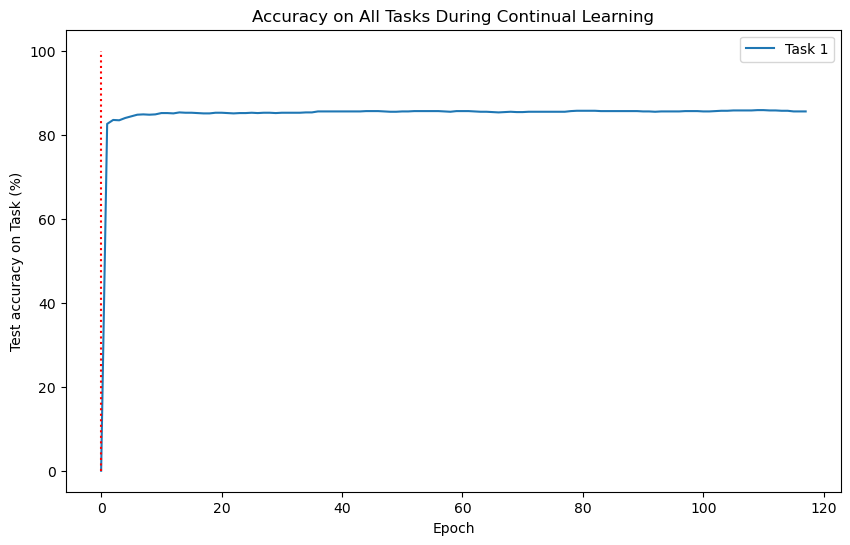

In [24]:

num_rounds = 1  # Number of datasets to create and train on
num_epochs = 5  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=784, output_dim=10, num_features=100_000, n_layers=2)  # Initialize the model
model = model.to(device)
model = perturb_model(model, 1e-4)

init_model = copy.deepcopy(model)
optimizer = NTKPruner(model.parameters(),init_model, prune_rate=0.01, momentum=0.99, cutoff_method='gaussian')

model = perturb_model(model, 1e-3)
eval_interval = 20

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(128)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optimizer, num_epochs,device, eval_interval, test_batches=10,log_edges=True)
    all_accuracies.append(accuracies)
    
plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader)

If the weights are small, we can also Taylor expand around 0. Now, pruning is truly pruning, and the "bad" weights are brought to zero.

Epoch 1/1 - Loss: 0.1335 - Restored edges: 0 / 79500010 - Test accuracy: 96.25%: 100%|██████████| 468/468 [00:30<00:00, 15.12it/s]


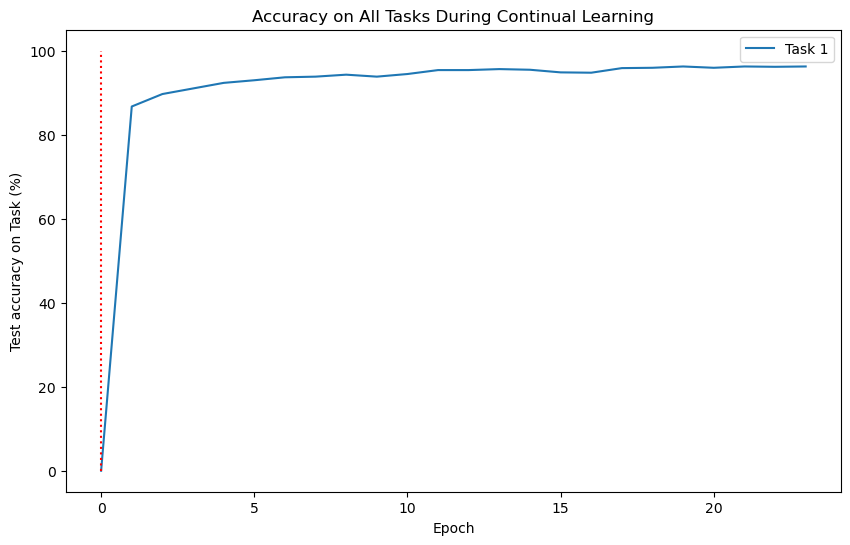

In [23]:

num_rounds = 1  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=784, output_dim=10, num_features=100_000, n_layers=2)  # Initialize the model
model = perturb_model(model.to(device), 1e-5)

init_model = None

optimizer = NTKPruner(model.parameters(),init_model, prune_rate=0.01, momentum=0.99, cutoff_method='gaussian')

eval_interval = 20

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(128)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optimizer, num_epochs,device, eval_interval, test_batches=10,log_edges=False)
    all_accuracies.append(accuracies)
    
plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader)

We can also prune after learning with SGD for a bit. it's important to note that performance actually *improves* due to pruning (up to a point).

Epoch 1/1 - Loss: 0.1399 - Restored edges: 0 / 79500010 - Test accuracy: 91.80%: 100%|██████████| 468/468 [00:11<00:00, 40.41it/s]
Epoch 1/1 - Loss: 0.0768 - Restored edges: 0 / 79500010 - Test accuracy: 95.70%: 100%|██████████| 468/468 [00:32<00:00, 14.47it/s]


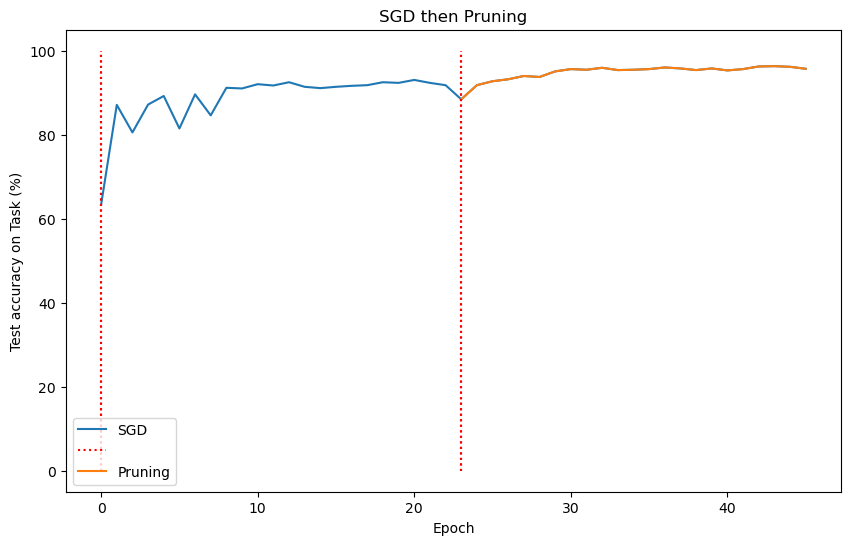

In [40]:

num_rounds = 2  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=784, output_dim=10, num_features=100_000, n_layers=2)  # Initialize the model
model = perturb_model(model.to(device), 1e-5)

init_model = None

train_loader, test_loader = shuffled_MNIST(128)  # Create new shuffled dataset

eval_interval = 20

for r in range(num_rounds):
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
        accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optim.SGD(model.parameters(),0.01), # note the high weight decay
                                 num_epochs,device, eval_interval, test_batches=10,log_edges=False)

    else:
        all_test_loaders.append(test_loader)

        # note this will inherit the momentum state
        optimizer = NTKPruner(model.parameters(),init_model, prune_rate=0.01, momentum=0.99, cutoff_method='gaussian')

        accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optimizer, num_epochs,device, eval_interval, test_batches=10,log_edges=False)
    all_accuracies.append(accuracies)
    
offset = len(train_loader) // eval_interval * num_epochs

plt.figure(figsize=(10, 6))
for i, accs in enumerate(all_accuracies):
    accs = np.concatenate([a.get(i,[]) for a in all_accuracies])

    plt.plot(range(i*offset,len(accs)+i*offset), accs)
    plt.vlines(range(0,num_rounds*offset, offset), 0, 100, linestyles=":", colors="r")
plt.xlabel('Epoch')
plt.ylabel('Test accuracy on Task (%)')
plt.title('SGD then Pruning')
plt.legend(["SGD", "","Pruning"])
plt.show()

Finally, let's look at continual learning. We'll learn 10 versions of MNIST, each for 1 epoch, and shuffle the pixels between each task.

Epoch 1/1 - Loss: 0.5250 - Restored edges: 10562368 / 79500010 - Test accuracy: 86.02%: 100%|██████████| 468/468 [00:29<00:00, 15.72it/s]
Epoch 1/1 - Loss: 0.8004 - Restored edges: 17728238 / 79500010 - Test accuracy: 84.06%: 100%|██████████| 468/468 [00:33<00:00, 13.84it/s]
Epoch 1/1 - Loss: 0.6276 - Restored edges: 25736950 / 79500010 - Test accuracy: 84.06%: 100%|██████████| 468/468 [00:40<00:00, 11.60it/s]
Epoch 1/1 - Loss: 0.8638 - Restored edges: 29949658 / 79500010 - Test accuracy: 80.70%: 100%|██████████| 468/468 [00:44<00:00, 10.62it/s]
Epoch 1/1 - Loss: 0.9046 - Restored edges: 33973403 / 79500010 - Test accuracy: 80.31%: 100%|██████████| 468/468 [00:46<00:00, 10.02it/s]
Epoch 1/1 - Loss: 0.9911 - Restored edges: 37758449 / 79500010 - Test accuracy: 79.06%: 100%|██████████| 468/468 [00:49<00:00,  9.39it/s]
Epoch 1/1 - Loss: 0.9948 - Restored edges: 41280665 / 79500010 - Test accuracy: 79.06%: 100%|██████████| 468/468 [00:53<00:00,  8.76it/s]
Epoch 1/1 - Loss: 1.0433 - Restore

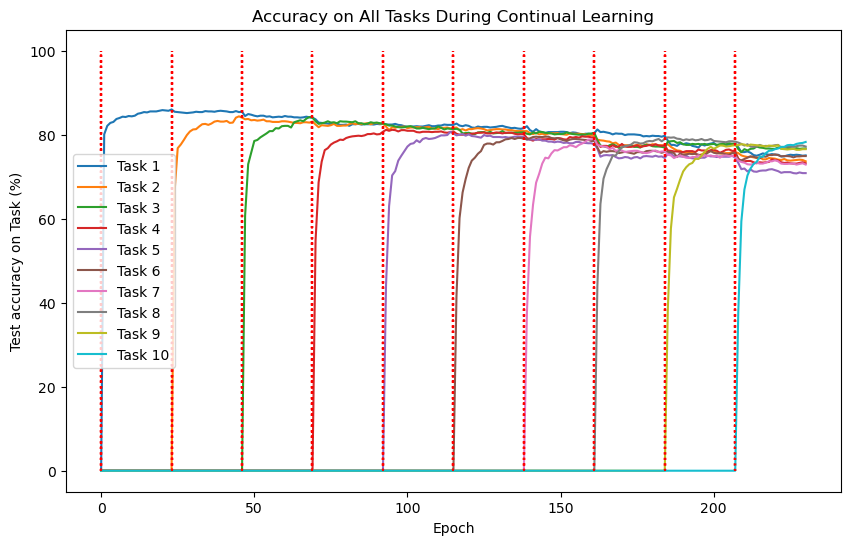

In [8]:

num_rounds = 10  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_dim=784, output_dim=10, num_features=100_000, n_layers=2)  # Initialize the model
model = model.to(device)
model = perturb_model(model, 1e-4)

init_model = copy.deepcopy(model)
optimizer = NTKPruner(model.parameters(),init_model, prune_rate=0.01, momentum=0.99, cutoff_method='gaussian')

model = perturb_model(model, 1e-3)
eval_interval = 20
# TODO make sure we're using the gradient at init, rather than at the current parameters, for the pruning. This is tricky because we need to multiply it by the actual network's output during backprop. (see next panel)

for r in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(128)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if r == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optimizer, num_epochs,device, eval_interval, test_batches=10,log_edges=True)
    all_accuracies.append(accuracies)
    
plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader)

## Taking the Product of Experts approach seriously.

What happens when instead of pruning each weight, we weigh it by the pruning probability function? This can be justified in a roundabout way (see Appendix in Overleaf.)

In [ ]:

class NTKPoE(optim.Optimizer):
    """
    This optimizer interprets the magnitude of each ∆W of (params - init_params) as a weight upon the
    estimators in a *Product* of Experts. This is what happens when you linearize the log likelihood of network (i.e. the loss)
    rather than the outputs of the network itself. See the Appendix for more details.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups
        temperature (float): lower temperatures are more aggressive in pruning
    """

    def __init__(self, params, init_model, temperature=1, beta=.9, prune_cutoff=1e-8, **kwargs):
        defaults = dict(temperature=temperature, beta=beta, prune_cutoff=prune_cutoff)
        super(NTKPoE, self).__init__(params, defaults)


        self.epsilon = 1e-12 ## Warning: this is too small for half precision
        self.temperature = temperature
        self.zero_init = init_model is None

        if len(self.param_groups) > 1:
            if init_model is None:
                self.init_param_groups_fn = lambda: [{'params': [None] * len(group['params'])} for group in self.param_groups]
            else:
                self.init_param_groups_fn = lambda: init_model.parameters()  # this function returns a generator. Better than storing list(params)
        else:
            if init_model is None:
                self.init_param_groups_fn = lambda: [{'params': [None] * len(self.param_groups[0]['params'])}]
            else:
                self.init_param_groups_fn = lambda: [{'params': init_model.parameters()}]
        
        # Check that no parameters are zero if no init model is supplied
        if self.zero_init:
            for group in self.param_groups:
                for p in group['params']:
                    assert not torch.any(p.data == 0), "A parameter is initialized to zero. This will prevent any learning on this parameter."


    def __setstate__(self, state):
        super(NTKPoE, self).__setstate__(state)

    def step(self, closure=None, loss=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable): A closure that re-evaluates the model, runs `backward`,
                and returns the loss.
        """

        
        if closure is not None:
            loss = closure()
        assert loss != None, "Either loss or closure must be supplied"
        loss = loss.detach()

        total_sum = sum(p.data.abs().sum() for p in model.parameters())
        log_total_sum = torch.log(total_sum)

        # take a proposed step.
        for group, init_param_group in zip(self.param_groups, self.init_param_groups_fn()):
            temperature = group['temperature']
            beta = group['beta']
            prune_cutoff = group['prune_cutoff']

            for p, p_c in zip(group['params'], init_param_group['params']):
                if p.grad is None:
                    continue
                d_p = p.grad.data

                if self.zero_init:
                    # If init_params is None, use the current gradients divided by 2 for linearization
                    delta_p = p.data
                    d_p = d_p / 2
                else:
                    # Compute ∆W and use it as the weight for NTK features
                    delta_p = p.data - p_c.data

                # store sign of weight
                sign_delta_p = torch.sign(delta_p)
                delta_p_abs = delta_p.abs()

                data_log_likelihood = -(sign_delta_p * d_p + loss/total_sum) / temperature
                
                if d_p.is_sparse:
                    raise NotImplementedError("Sparse tensors are not supported yet")
                    p.grad.data = filtered_v

                else:
                    if beta > 0:
                        param_state = self.state[p]
                        if 'beta_buffer' not in param_state:
                            v = param_state['beta_buffer'] = torch.zeros_like(p.data)
                            v.mul_(beta).add_(data_log_likelihood * (1 - beta))
                        else:
                            v = param_state['beta_buffer']
                            v.mul_(beta).add_(data_log_likelihood * (1 - beta))
                    else:
                        v = data_log_ikelihood
                
                    ## operate in log space for numerical stability. This requires that we skip elements that are already 0.
                    nonzero_mask = delta_p_abs > prune_cutoff

                    # preserve scale. This is a hack to make sure the params in small param groups stay small 
                    # (since we're not computing logsumexp over all parameters in the whole network, just one group at a time)
                    log_delta_p_scale = delta_p_abs.sum().log()

                    # Update ∆W based on the gradient and temperature
                    log_delta_p_unsigned = torch.log(delta_p_abs+self.epsilon) + v

                    # Normalize mag(∆W) to sum to 1 for this parameter group, then multiply by delta_p_scale to recover scale
                    log_delta_p_unsigned += log_delta_p_scale - torch.logsumexp(log_delta_p_unsigned, dim=list(range(len(p.size()))))

                    delta_p = sign_delta_p * torch.exp(log_delta_p_unsigned)

                    # return elements that were already below the cutoff to zero
                    delta_p = delta_p * nonzero_mask

                    # Update the parameter. 
                    if self.zero_init:
                        p.data = delta_p # a no-op
                    else:
                        p.data = delta_p + p_c.data

        return loss

def train_and_evaluate(model, train_loader, test_loaders, optimizer, num_epochs, device, eval_interval, test_batches=10,log_edges=False):
    model.to(device)  # Move the model to the appropriate device
    all_accuracies = {i: [] for i in range(len(test_loaders))}  # Dictionary to store accuracies
    total_edges = count_total_edges(model)
    batch_count = 0  # Counter for tracking the number of batches
    accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
            for data, target in t:
                data, target = data.to(device), target.to(device)  # Move data to the appropriate device
                optimizer.zero_grad()
                output = model(data)
                loss = nn.CrossEntropyLoss()(output, target)
                loss.backward()
                if isinstance(optimizer, NTKPoE):
                    optimizer.step(loss=loss)
                else:
                    optimizer.step()
                batch_count += 1

                if batch_count % eval_interval == 0:
                    model.eval()
                    with torch.no_grad():
                        for i, test_loader in enumerate(test_loaders):
                            correct = 0
                            total = 0
                            j = 0
                            for data, target in test_loader:
                                data, target = data.to(device), target.to(device)
                                output = model(data)
                                _, predicted = torch.max(output.data, 1)
                                total += target.size(0)
                                correct += (predicted == target).sum().item()
                                j += 1
                                if j >= test_batches:
                                    break
                            accuracy = 100 * correct / total
                            all_accuracies[i].append(accuracy)
                    model.train()

                n_zero_edges = number_equal_edges(model.parameters(), optimizer.init_param_groups_fn()[0]['params']) if log_edges else 0
                t.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f} - Restored edges: {n_zero_edges} / {total_edges} - Test accuracy: {accuracy:.2f}%")

    return all_accuracies


Epoch 1/1 - Loss: 0.2758 - Restored edges: 0 / 79500010 - Test accuracy: 91.41%: 100%|██████████| 468/468 [00:17<00:00, 27.01it/s]
Epoch 1/1 - Loss: 0.3930 - Restored edges: 0 / 79500010 - Test accuracy: 89.84%: 100%|██████████| 468/468 [00:18<00:00, 25.53it/s]
Epoch 1/1 - Loss: 0.4495 - Restored edges: 0 / 79500010 - Test accuracy: 89.84%: 100%|██████████| 468/468 [00:19<00:00, 24.21it/s]
Epoch 1/1 - Loss: 0.4301 - Restored edges: 0 / 79500010 - Test accuracy: 89.58%: 100%|██████████| 468/468 [00:20<00:00, 23.04it/s]
Epoch 1/1 - Loss: 0.3722 - Restored edges: 0 / 79500010 - Test accuracy: 90.89%: 100%|██████████| 468/468 [00:21<00:00, 21.98it/s]
Epoch 1/1 - Loss: 0.4054 - Restored edges: 0 / 79500010 - Test accuracy: 90.62%: 100%|██████████| 468/468 [00:22<00:00, 20.99it/s]
Epoch 1/1 - Loss: 0.3726 - Restored edges: 0 / 79500010 - Test accuracy: 89.06%: 100%|██████████| 468/468 [00:23<00:00, 20.09it/s]
Epoch 1/1 - Loss: 0.3246 - Restored edges: 0 / 79500010 - Test accuracy: 90.62%: 10

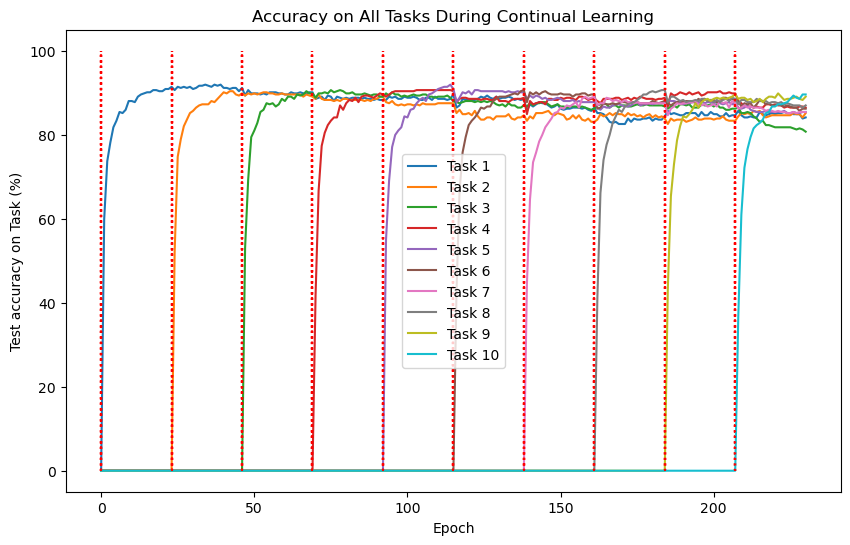

In [ ]:



num_rounds = 10  # Number of datasets to create and train on
num_epochs = 1  # Number of epochs to train on each dataset
all_accuracies = []

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device='cpu'
model = MLP(input_dim=784, output_dim=10, num_features=100000, n_layers=2)  # Initialize the model
model = model.to(device)
model = perturb_model(model, 1e-3)
reinitialize_with_sign(model, magnitude=1e-2)
# init_model = copy.deepcopy(model)
optimizer = NTKPoE(model.parameters(),init_model=None, temperature=5, beta=0.9, prune_cutoff=1e-29)

# model = perturb_model_bernoulli(model, 1e-3)

eval_interval = 20

for round in range(num_rounds):
    train_loader, test_loader = shuffled_MNIST(128)  # Create new shuffled dataset
    # Update all test loaders to include the new test set
    if round == 0:
        all_test_loaders = [test_loader]
        # start on a good foot
    else:
        all_test_loaders.append(test_loader)

    # Train the model and evaluate on all datasets
    accuracies = train_and_evaluate(model, train_loader, all_test_loaders, optimizer, num_epochs,device, eval_interval, test_batches=3,log_edges=False)
    all_accuracies.append(accuracies)
    
plot_accuracies(all_accuracies, num_epochs, num_rounds, eval_interval, train_loader)